# Natural language processing of Trump's tweets and stock price prediction

This is an analysis to perform natural language processing to Trump's tweets and predict stock price up and down in the next day based on today's tweets. With using free Twitter Developer account, we can't get historical tweet data, but Trump has his own archive of historical tweets, so we use it for this analysis. The archive is http://www.trumptwitterarchive.com/archive.

## Setup

In [68]:
# basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader import data

# natural language processing
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# modeling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB

## Data

In [2]:
tweet_df = pd.read_csv("Trump_tweet_archibe_01012017-08122019.csv")

In [3]:
tweet_df.head()

,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str
0,Twitter for iPhone,The United States is learning much from the fa...,8/12/2019 21:26,17872.0,72500.0,False,1.161030e+18
1,Twitter for iPhone,Two great and loyal friends! https://t.co/Fo2C...,8/12/2019 19:47,25877.0,124637.0,False,1.161000e+18
2,Twitter for iPhone,Scaramucci who like so many others had nothing...,8/12/2019 19:31,15898.0,78221.0,False,1.161000e+18
3,Twitter for iPhone,Thank you NEGOP! https://t.co/S5A24nleW8,8/12/2019 4:01,17833.0,83779.0,False,1.160760e+18
4,Twitter for iPhone,Many incredible things are happening right now...,8/11/2019 21:42,28385.0,128219.0,False,1.160670e+18


In [4]:
print(tweet_df.shape)

(7880, 7)


In [5]:
# setting time series
tweet_df['created_at'] = pd.to_datetime(tweet_df['created_at'])
tweet_df = tweet_df.set_index('created_at')
tweet_df.index = tweet_df.index.tz_localize('UTC').tz_convert('EST')

In [6]:
tweet_df.head()

,source,text,retweet_count,favorite_count,is_retweet,id_str
created_at,,,,,,
2019-08-12 16:26:00-05:00,Twitter for iPhone,The United States is learning much from the fa...,17872.0,72500.0,False,1.161030e+18
2019-08-12 14:47:00-05:00,Twitter for iPhone,Two great and loyal friends! https://t.co/Fo2C...,25877.0,124637.0,False,1.161000e+18
2019-08-12 14:31:00-05:00,Twitter for iPhone,Scaramucci who like so many others had nothing...,15898.0,78221.0,False,1.161000e+18
2019-08-11 23:01:00-05:00,Twitter for iPhone,Thank you NEGOP! https://t.co/S5A24nleW8,17833.0,83779.0,False,1.160760e+18
2019-08-11 16:42:00-05:00,Twitter for iPhone,Many incredible things are happening right now...,28385.0,128219.0,False,1.160670e+18


## EDA

In [7]:
count_daily = tweet_df['source'].resample('D').count()

mean = np.mean(count_daily)
std = np.std(count_daily)
print("Average number of daily tweets: {:.2f}".format(mean))
print("Standard deviation of daily tweets: {:.2f}".format(std))

Average number of daily tweets: 8.26
Standard deviation of daily tweets: 5.10


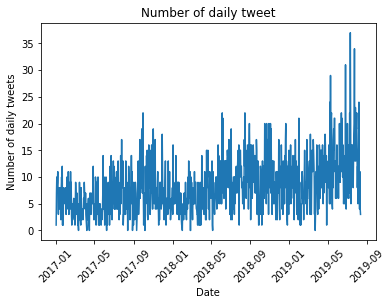

In [104]:
plt.plot(count_daily.index, count_daily)
plt.title('Number of daily tweet')
plt.xlabel('Date')
plt.ylabel('Number of daily tweets')
plt.xticks(rotation = 45)
plt.show()

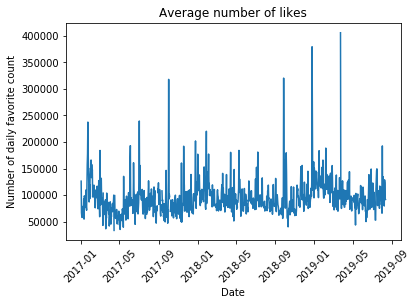

In [110]:
favorite_daily = tweet_df['favorite_count'].resample('D').mean()

plt.plot(favorite_daily.index, favorite_daily)
plt.title('Average number of likes')
plt.xlabel('Date')
plt.ylabel('Number of daily favorite count')
plt.xticks(rotation = 45)
plt.show()

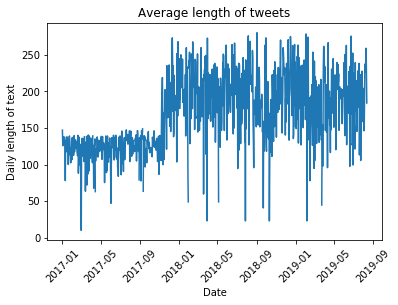

In [119]:
tweet_df['length_text'] = tweet_df.text.str.len()

length_daily = tweet_df['length_text'].resample('D').mean()

plt.plot(length_daily.index, length_daily)
plt.title('Average length of tweets')
plt.xlabel('Date')
plt.ylabel('Daily length of text')
plt.xticks(rotation = 45)
plt.show()

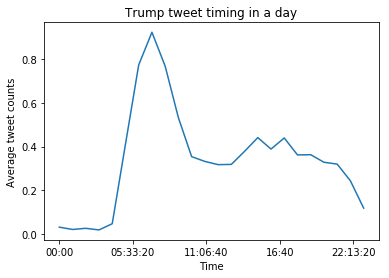

In [120]:
count_hourly = tweet_df['source'].resample('H').count()
count_hourly = count_hourly.groupby(count_hourly.index.time).mean()

plt.plot(count_hourly.index, count_hourly)
plt.title('Trump tweet timing in a day')
plt.xlabel('Time')
plt.ylabel('Average tweet counts')
plt.show()

## Sentiment

In [14]:
# initiate
sia = SentimentIntensityAnalyzer()

# calculate sentiment score
sentiment_score = tweet_df['text'].apply(sia.polarity_scores)

# merge
sentiment_score_df = pd.DataFrame.from_records(sentiment_score)
sentiment_score_df = sentiment_score_df.set_index(sentiment_score.index)
tweet_df = pd.concat([tweet_df, sentiment_score_df], axis = 1)

In [15]:
tweet_df.head(2)

,source,text,retweet_count,favorite_count,is_retweet,id_str,length_text,compound,neg,neu,pos
created_at,,,,,,,,,,,
2019-08-12 16:26:00-05:00,Twitter for iPhone,The United States is learning much from the fa...,17872.0,72500.0,False,1.161030e+18,239,-0.4775,0.177,0.713,0.110
2019-08-12 14:47:00-05:00,Twitter for iPhone,Two great and loyal friends! https://t.co/Fo2C...,25877.0,124637.0,False,1.161000e+18,52,0.8908,0.000,0.221,0.779


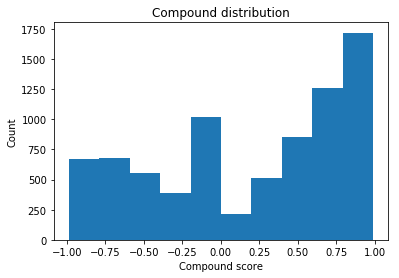

In [16]:
plt.hist(tweet_df['compound'])
plt.title('Compound distribution')
plt.xlabel('Compound score')
plt.ylabel('Count')
plt.show()

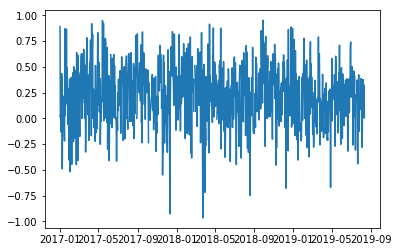

In [17]:
compound_daily = tweet_df['compound'].resample('D').mean()

plt.plot(compound_daily.index, compound_daily)
plt.show()

## Tokenization

In [18]:
n = tweet_df.shape[0]
tokens_list = []

for i in range(n):
    text = tweet_df['text'][i]
    tokens = [w for w in word_tokenize(text.lower()) if w.isalpha()]
    no_stops = [t for t in tokens if t not in stopwords.words('english')]
    customized = [c for c in no_stops if c not in ['http', 'https', 'amp']]
    tokens_list.append(customized)
    
tweet_df['token'] = tokens_list
tweet_df.head()

,source,text,retweet_count,favorite_count,is_retweet,id_str,length_text,compound,neg,neu,pos,token
created_at,,,,,,,,,,,,
2019-08-12 16:26:00-05:00,Twitter for iPhone,The United States is learning much from the fa...,17872.0,72500.0,False,1.161030e+18,239,-0.4775,0.177,0.713,0.110,"[united, states, learning, much, failed, missi..."
2019-08-12 14:47:00-05:00,Twitter for iPhone,Two great and loyal friends! https://t.co/Fo2C...,25877.0,124637.0,False,1.161000e+18,52,0.8908,0.000,0.221,0.779,"[two, great, loyal, friends]"
2019-08-12 14:31:00-05:00,Twitter for iPhone,Scaramucci who like so many others had nothing...,15898.0,78221.0,False,1.161000e+18,261,-0.4003,0.101,0.829,0.070,"[scaramucci, like, many, others, nothing, elec..."
2019-08-11 23:01:00-05:00,Twitter for iPhone,Thank you NEGOP! https://t.co/S5A24nleW8,17833.0,83779.0,False,1.160760e+18,40,0.4199,0.000,0.518,0.482,"[thank, negop]"
2019-08-11 16:42:00-05:00,Twitter for iPhone,Many incredible things are happening right now...,28385.0,128219.0,False,1.160670e+18,251,0.9006,0.000,0.780,0.220,"[many, incredible, things, happening, right, c..."


## Word cloud

In [19]:
joined_tweet = []

for i in range(tweet_df.shape[0]):
    joined_tweet = joined_tweet + tweet_df['token'][i] 

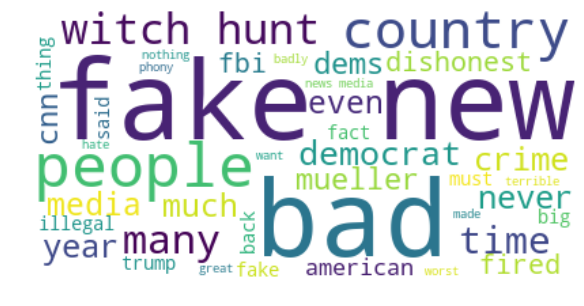

In [126]:
sep = ' '
joined_tweet_str = sep.join(joined_tweet)

SEED = 1

cloud = WordCloud(max_words = 40, background_color = 'white', random_state = SEED).generate(joined_tweet_str)

plt.figure(figsize = (15, 5))
plt.imshow(cloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

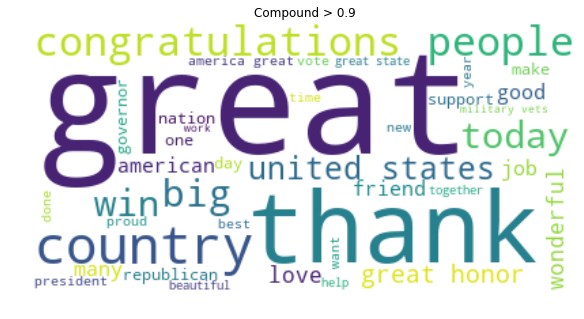

In [127]:
# positive
positive = tweet_df.loc[tweet_df['compound'] > 0.9, :]

# join tokens
joined_tweet = []
for i in range(positive.shape[0]):
    joined_tweet = joined_tweet + positive['token'][i] 
    
# make word cloud
sep = ' '
joined_tweet_str = sep.join(joined_tweet)
SEED = 1
cloud = WordCloud(max_words = 40, background_color = 'white', random_state = SEED).generate(joined_tweet_str)

plt.figure(figsize = (15, 5))
plt.imshow(cloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Compound > 0.9')
plt.show()

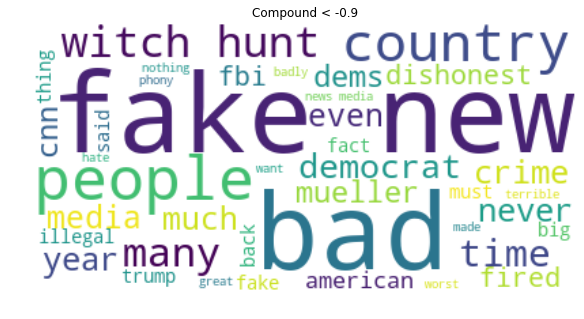

In [128]:
# negative
negative = tweet_df.loc[tweet_df['compound'] < -0.9, :]

# join tokens
joined_tweet = []
for i in range(negative.shape[0]):
    joined_tweet = joined_tweet + negative['token'][i] 
    
# make word cloud
sep = ' '
joined_tweet_str = sep.join(joined_tweet)
SEED = 1
cloud = WordCloud(max_words = 40, background_color = 'white', random_state = SEED).generate(joined_tweet_str)

plt.figure(figsize = (15, 5))
plt.imshow(cloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Compound < -0.9')
plt.show()

## Word frequency

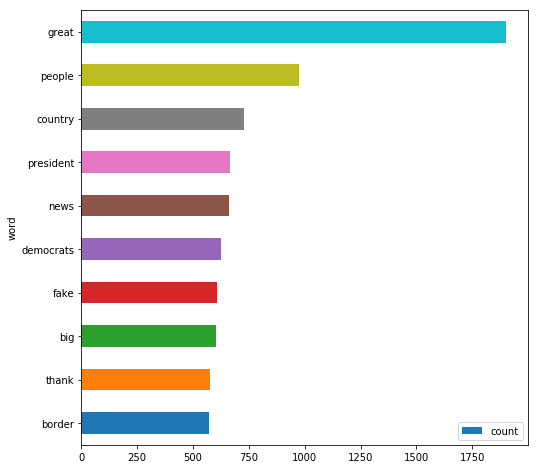

In [130]:
joined_tweet = []

for i in range(tweet_df.shape[0]):
    joined_tweet = joined_tweet + tweet_df['token'][i] 
    
counter = Counter(joined_tweet)
freq_df = pd.DataFrame(counter.most_common(10), columns = ['word', 'count'])

fig, ax = plt.subplots(figsize = (8, 8))
freq_df.sort_values(by = 'count').plot.barh(x = 'word', y = 'count', ax = ax)
plt.show()

## Stock price

In [24]:
print(min(tweet_df.index))
print(max(tweet_df.index))

2017-01-01 00:00:00-05:00
2019-08-12 16:26:00-05:00


In [25]:
start = '2017-01-01'
end = '2019-08-12'
sp = data.DataReader('^GSPC', 'yahoo', start, end)
sp.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-01-03,2263.879883,2245.129883,2251.570068,2257.830078,3770530000,2257.830078
2017-01-04,2272.820068,2261.600098,2261.600098,2270.750000,3764890000,2270.750000
2017-01-05,2271.500000,2260.449951,2268.179932,2269.000000,3761820000,2269.000000
2017-01-06,2282.100098,2264.060059,2271.139893,2276.979980,3339890000,2276.979980
2017-01-09,2275.489990,2268.899902,2273.590088,2268.899902,3217610000,2268.899902


In [37]:
# 2017-01-04 0.005722 means up from 01-03
up_df = sp['Close'].pct_change().dropna() > 0
up_df.head()

Date
2017-01-04     True
2017-01-05    False
2017-01-06     True
2017-01-09    False
2017-01-10    False
Name: Close, dtype: bool

## Daily tweet

In [131]:
tweet_df['date'] = tweet_df.index.date

In [28]:
date_list = np.unique(tweet_df['date'])

list_daily_tweet = []

for i in range(len(date_list)):
    tweet_one_day = tweet_df.loc[tweet_df['date'] == date_list[i], 'text']
    temp = ""
    for text in tweet_one_day:
        temp = temp + " " + text
    
    list_daily_tweet.append(temp)

In [29]:
daily_df = pd.DataFrame(data = {'date': date_list,
                                'text': list_daily_tweet})
daily_df = daily_df.dropna()
daily_df.reset_index(inplace = True, drop = True)
daily_df.head()

,date,text
0,2017-01-01,TO ALL AMERICANS-#HappyNewYear &amp; many ble...
1,2017-01-02,China has been taking out massive amounts of ...
2,2017-01-03,"The ""Intelligence"" briefing on so-called ""Rus..."
3,2017-01-04,Jackie Evancho's album sales have skyrocketed...
4,2017-01-05,So how and why are they so sure about hacking...


In [30]:
n = daily_df.shape[0]
joined_list = []
sep = " "

for i in range(n):
    # get each tweet
    text = daily_df['text'][i]
    # tokenize only alphabetical words with lowercase
    tokens = [w for w in word_tokenize(text.lower()) if w.isalpha()]
    # remove stop words to get only more meaningful words for analysis
    no_stops = [t for t in tokens if t not in stopwords.words('english')]
    # customized filtering
    customized = [c for c in no_stops if c not in ["https", "http", "amp"]]
    # make it one text
    one_text = sep.join(customized)
    
    joined_list.append(one_text)

daily_df['tokenized'] = joined_list
daily_df.head()

,date,text,tokenized
0,2017-01-01,TO ALL AMERICANS-#HappyNewYear &amp; many ble...,happynewyear many blessings looking forward wo...
1,2017-01-02,China has been taking out massive amounts of ...,china taking massive amounts money wealth tota...
2,2017-01-03,"The ""Intelligence"" briefing on so-called ""Rus...",intelligence briefing russian hacking delayed ...
3,2017-01-04,Jackie Evancho's album sales have skyrocketed...,jackie evancho album sales skyrocketed announc...
4,2017-01-05,So how and why are they so sure about hacking...,sure hacking never even requested examination ...


In [31]:
daily_df = daily_df.set_index('date')

In [32]:
daily_df.head()

,text,tokenized
date,,
2017-01-01,TO ALL AMERICANS-#HappyNewYear &amp; many ble...,happynewyear many blessings looking forward wo...
2017-01-02,China has been taking out massive amounts of ...,china taking massive amounts money wealth tota...
2017-01-03,"The ""Intelligence"" briefing on so-called ""Rus...",intelligence briefing russian hacking delayed ...
2017-01-04,Jackie Evancho's album sales have skyrocketed...,jackie evancho album sales skyrocketed announc...
2017-01-05,So how and why are they so sure about hacking...,sure hacking never even requested examination ...


In [49]:
daily_df.shape

(941, 2)

## Merge

True at 01-04 row of up_df means stock price up from 01-03 to 01-04.

In [38]:
up_df = up_df.reset_index()

In [41]:
up_df['merge_date'] = up_df['Date'] - pd.DateOffset(days = 1)

In [43]:
up_df = up_df.set_index('merge_date')

In [44]:
up_df.head()

,Date,Close
merge_date,,
2017-01-03,2017-01-04,True
2017-01-04,2017-01-05,False
2017-01-05,2017-01-06,True
2017-01-08,2017-01-09,False
2017-01-09,2017-01-10,False


In [50]:
merge_df = pd.concat([up_df, daily_df], axis = 1)
print(merge_df.shape)
print(merge_df.head())

(950, 4)
                 Date  Close  \
2017-01-01        NaT    NaN   
2017-01-02        NaT    NaN   
2017-01-03 2017-01-04   True   
2017-01-04 2017-01-05  False   
2017-01-05 2017-01-06   True   

                                                         text  \
2017-01-01   TO ALL AMERICANS-#HappyNewYear &amp; many ble...   
2017-01-02   China has been taking out massive amounts of ...   
2017-01-03   The "Intelligence" briefing on so-called "Rus...   
2017-01-04   Jackie Evancho's album sales have skyrocketed...   
2017-01-05   So how and why are they so sure about hacking...   

                                                    tokenized  
2017-01-01  happynewyear many blessings looking forward wo...  
2017-01-02  china taking massive amounts money wealth tota...  
2017-01-03  intelligence briefing russian hacking delayed ...  
2017-01-04  jackie evancho album sales skyrocketed announc...  
2017-01-05  sure hacking never even requested examination ...  


In [52]:
merge_df = merge_df.dropna()
merge_df.shape

(646, 4)

## Model data

In [56]:
merge_df['target'] = [1 if x == True else 0 for x in merge_df['Close']]
merge_df.head()

,Date,Close,text,tokenized,target
2017-01-03,2017-01-04,True,"The ""Intelligence"" briefing on so-called ""Rus...",intelligence briefing russian hacking delayed ...,1
2017-01-04,2017-01-05,False,Jackie Evancho's album sales have skyrocketed...,jackie evancho album sales skyrocketed announc...,0
2017-01-05,2017-01-06,True,So how and why are they so sure about hacking...,sure hacking never even requested examination ...,1
2017-01-08,2017-01-09,False,Dishonest media says Mexico won't be paying f...,dishonest media says mexico wo paying wall pay...,0
2017-01-09,2017-01-10,False,Thank you to all of the men and women who pro...,thank men women protect serve communities old ...,0


In [61]:
SIZE = 0.3
SEED = 1

X_train, X_test, y_train, y_test = train_test_split(merge_df['tokenized'], 
                                                    merge_df['target'], 
                                                    test_size = SIZE, 
                                                    random_state = SEED)

CountVectorizer(ngram_range = (min_n, max_n), max_df, min_df)

In [65]:
vect = CountVectorizer(max_features = 50)

count_train = vect.fit_transform(X_train.values)
count_test = vect.transform(X_test.values)

count_train_array = count_train.toarray()
count_test_array = count_test.toarray()

count_train_df = pd.DataFrame(count_train_array, columns = vect.get_feature_names())
count_test_df = pd.DataFrame(count_test_array, columns = vect.get_feature_names())
count_train_df.head()

,america,american,back,bad,big,border,china,country,crime,deal,...,tax,thank,time,today,trump,united,wall,want,would,years
0,1,0,1,0,0,0,0,0,0,0,...,1,2,2,0,0,2,0,0,0,0
1,0,0,0,1,2,2,0,0,0,0,...,0,1,0,1,0,0,2,1,2,0
2,0,1,0,1,1,0,0,1,1,0,...,0,3,0,0,1,1,0,2,1,0
3,0,0,0,1,0,1,0,3,1,0,...,0,2,0,0,1,0,1,1,0,3
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,2,1,0,0,0,0


In [66]:
count_test_df.head()

,america,american,back,bad,big,border,china,country,crime,deal,...,tax,thank,time,today,trump,united,wall,want,would,years
0,1,1,2,0,6,0,0,0,4,0,...,1,0,0,3,3,0,0,1,1,2
1,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2,1,0,2,1,1,0,1,...,0,0,0,1,2,1,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,1,0,1,0,0,0
4,0,1,1,0,1,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,3


Naive Bayes can use many features, and can perform well even with irrelevant features, so it's convenient in using text features.

In [72]:
nb_classifier = MultinomialNB()

nb_classifier.fit(count_train, y_train)
y_test_pred = nb_classifier.predict(count_test)

score = accuracy_score(y_test, y_test_pred)
print("Accuracy in test set: {:.2f}".format(score))

Accuracy in test set: 0.47


In [74]:
confusion_matrix(y_test, y_test_pred, labels = [0, 1])

array([[31, 47],
       [55, 61]], dtype=int64)

## N-gram model

In [87]:
vect = CountVectorizer(max_features = 10, ngram_range = (3, 3))

count_train = vect.fit_transform(X_train.values)
count_test = vect.transform(X_test.values)

nb_classifier = MultinomialNB()

nb_classifier.fit(count_train, y_train)
y_test_pred = nb_classifier.predict(count_test)

score = accuracy_score(y_test, y_test_pred)
print("Accuracy in test set: {:.2f}".format(score))

Accuracy in test set: 0.58


## Cross validation

In [94]:
gram = np.arange(1, 11, 1)
score_list = []

for i in gram:
    
    vect = CountVectorizer(max_features = 20, ngram_range = (i, i))

    count_train = vect.fit_transform(X_train.values)
    count_test = vect.transform(X_test.values)

    nb_classifier = MultinomialNB()

    nb_classifier.fit(count_train, y_train)
    y_test_pred = nb_classifier.predict(count_test)

    score = accuracy_score(y_test, y_test_pred)

    score_list.append(score)

score_list

[0.5051546391752577,
 0.5309278350515464,
 0.5773195876288659,
 0.6134020618556701,
 0.5927835051546392,
 0.6030927835051546,
 0.6030927835051546,
 0.5876288659793815,
 0.5979381443298969,
 0.5979381443298969]

In [97]:
gram = np.arange(1, 11, 1)
feature = np.arange(10, 51, 10)

score_mat = np.zeros((len(feature), len(gram)))

for j in range(len(feature)):

    for i in range(len(gram)):

        vect = CountVectorizer(max_features = feature[j], ngram_range = (gram[i], gram[i]))

        count_train = vect.fit_transform(X_train.values)
        count_test = vect.transform(X_test.values)

        nb_classifier = MultinomialNB()

        nb_classifier.fit(count_train, y_train)
        y_test_pred = nb_classifier.predict(count_test)

        score = accuracy_score(y_test, y_test_pred)

        score_mat[j, i] = score

score_mat

array([[0.5       , 0.56185567, 0.58247423, 0.60824742, 0.60309278,
        0.59793814, 0.59793814, 0.59793814, 0.59793814, 0.59793814],
       [0.50515464, 0.53092784, 0.57731959, 0.61340206, 0.59278351,
        0.60309278, 0.60309278, 0.58762887, 0.59793814, 0.59793814],
       [0.49484536, 0.51546392, 0.54639175, 0.6185567 , 0.59278351,
        0.59278351, 0.60309278, 0.58762887, 0.59793814, 0.59793814],
       [0.45876289, 0.51030928, 0.54123711, 0.6185567 , 0.59278351,
        0.59278351, 0.60309278, 0.58762887, 0.59793814, 0.59793814],
       [0.4742268 , 0.5257732 , 0.53608247, 0.62371134, 0.59793814,
        0.59278351, 0.60309278, 0.58762887, 0.59278351, 0.59793814]])

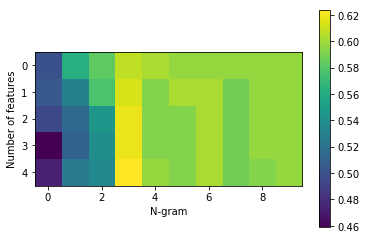

In [99]:
plt.imshow(score_mat)
plt.xlabel('N-gram')
plt.ylabel('Number of features')
plt.colorbar()
plt.show()

## Inspection

In [102]:
vect = CountVectorizer(max_features = 30, ngram_range = (4, 4))

count_train = vect.fit_transform(X_train.values)
count_train_array = count_train.toarray()
count_train_df = pd.DataFrame(count_train_array, columns = vect.get_feature_names())
count_train_df.shape

(452, 30)

In [118]:
count_train_df.sum(axis = 0)

amendment loves military vets           5
borders loves military vets             6
crime borders loves military            4
crimes committed crooked hillary        4
crooked hillary clinton democrats       4
democrats want open borders             6
failing new york times                 14
fake news media going                   4
fema first responders law               4
first responders law enforcement        5
flotus melania honored welcome          5
great honor welcome president           8
great honor welcome prime               6
honor welcome prime minister            6
jong un north korea                     6
kim jong un north                       6
look forward seeing everyone            6
make america great rally                5
make america great thank                4
meeting kim jong un                     4
news media going crazy                  4
pleased announce intention nominate     4
prime minister abe japan                6
prime minister abeshinzo japan    